In [1]:
"""
Data visualization
Author: Xionghui Xu
Date: July 11, 2025
"""
import os
import numpy as np
import xarray as xr
import pandas as pd
import netCDF4 as nc
import geopandas as gpd
import rioxarray as rxr
from concurrent.futures import ThreadPoolExecutor
import warnings
from pathlib import Path

In [2]:
#### Here we set the configuration
resolution = "500"
region = [-180,180,-60,90]
data_path = f'data/run/'
shp_path = 'data/Shp/'
field_path = 'data/field/'
fig_path = 'fig/'

# Visualization

## 1. Data Export

In [3]:
def load_and_flatten_data(file_name, variable_name, index=None, path='data/run/'):
    try:
        with nc.Dataset(f"{path}{file_name}.nc4") as dataset:
            data = dataset[variable_name][index, :, :].flatten() if index is not None else dataset[variable_name][:, :].flatten()
        return data
    except Exception as e:
        warnings.warn(f"Error loading {file_name}.nc4 or variable {variable_name}: {e}")
        return None

def load_lat_lon(data_path):
    try:
        with nc.Dataset(f"{data_path}masking_criteria/mask_combine_all.nc4") as dataset:
            lat = dataset['lat'][:]
            lon = dataset['lon'][:]
            # Use meshgrid for efficient grid creation
            lon_grid, lat_grid = np.meshgrid(lon, lat)
            return lat_grid.ravel(), lon_grid.ravel()
    except Exception as e:
        warnings.warn(f"Error loading lat/lon from masking_criteria/mask_combine_all.nc4: {e}")
        return None, None

def load_all_data(file_variable_list, data_path='data/run/'):
    # Initialize DataFrame
    df = pd.DataFrame()

    # Load lat/lon first
    lat, lon = load_lat_lon(data_path)
    if lat is None or lon is None:
        raise RuntimeError("Failed to load latitude/longitude data")
    df['lat'] = lat
    df['lon'] = lon

    # Load other variables
    for file_name, variable_name, index in file_variable_list:
        data = load_and_flatten_data(file_name, variable_name, index, data_path)
        if data is not None:
            df[file_name] = data

    return df

def assign_geo_attributes(df, continent_file='continent/continent.shp', 
                         country_file='World_CN/ne_10m_admin_0_countries_chn.shp'):
    """
    Assign continent, subregion, and country attributes to DataFrame points based on shapefiles.
    """
    shp1 = gpd.read_file(shp_path+continent_file)
    shp2 = gpd.read_file(shp_path+country_file)
    df = df.reset_index(drop=True)
    gdf_points = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df['lon'], df['lat'], crs='EPSG:4326'))


    result1 = gpd.sjoin(gdf_points, shp1, how='left', predicate='within')
    result2 = gpd.sjoin(gdf_points, shp2, how='left', predicate='within')

    df['Continent'] = result1['CONTINENT']
    df['Subregion'] = result2['SUBREGION']
    df['Sovereignt'] = result2['SOVEREIGNT']
    df['Continent'] = df['Continent'].replace('Australia', 'Oceania')

    return df

# Configuration
file_variable_list = [
    ('masking_criteria/mask_combine_all', 'Band1', None),
    # ('Dbedrock_Frequency', 'Dbedrock', None),
    ('Sbedrock', 'Band1', None),
    ('Area', 'area', None),
    # ('Koppen', 'Band1', None),
    # ('IGBP', 'LC', 0),
    ('PR_mean', 'tp', 0),
]

df = load_all_data(file_variable_list, data_path)
df = df[df['masking_criteria/mask_combine_all'] == 1]
df = df.drop(columns=['masking_criteria/mask_combine_all'])
df = assign_geo_attributes(df)

df

,lat,lon,Sbedrock,Area,PR_mean,Continent,Subregion,Sovereignt
0,-55.847915,-67.627077,0.236460,120515.621801,692.439941,South America,South America,Chile
1,-55.847915,-67.622911,0.279453,120515.621801,691.950134,South America,South America,Chile
2,-55.847915,-67.618744,0.322446,120515.621801,691.460266,South America,South America,Chile
3,-55.847915,-67.614577,0.365440,120515.621801,690.970398,South America,South America,Chile
4,-55.847915,-67.610411,0.408433,120515.621801,690.480591,South America,South America,Chile
...,...,...,...,...,...,...,...,...
157069426,82.960426,-26.739575,39.301605,26309.225697,125.175171,North America,Northern America,Denmark
157069427,82.960426,-26.735409,39.884819,26309.225697,125.231812,North America,Northern America,Denmark
157069428,82.960426,-26.731242,40.468037,26309.225697,125.288445,North America,Northern America,Denmark
157069429,82.960426,-26.727075,41.051250,26309.225697,125.345085,North America,Northern America,Denmark


## 2. Plotting

In [4]:
%matplotlib inline

import geopandas as gpd
from pylab import rcParams
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.font_manager as fm
from matplotlib.gridspec import GridSpec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [ ]:
pd.set_option('display.max_columns', None)

params = {'font.family': 'Arial',
          'backend': 'ps',
          'axes.labelsize': 25,
          'grid.linewidth': 0.2,
          'font.size': 25,
          'legend.fontsize': 18,
          'legend.frameon': False,
          'xtick.labelsize': 30,
          'xtick.direction': 'out',
          'ytick.labelsize': 30,
          'ytick.direction': 'out',
          'legend.handlelength': 1,
          'legend.handleheight': 1,
          'savefig.bbox': 'tight',
          'axes.unicode_minus': False,
          "mathtext.default":"regular",
          'text.usetex': False}
rcParams.update(params)

font_properties = fm.FontProperties(family='Arial', weight='bold')
size = 0.0005

### 2.1 Figs. 2b-2g

In [6]:
def process_geo_data(df, group_by, area_threshold=1000, sample_size=10000, name_mapping=None):
    """
    Process DataFrame to compute areas, filter, and sample Sbedrock values by group.
    """
    # Apply name mapping if provided
    df = df.copy()
    if name_mapping:
        df[group_by] = df[group_by].map(name_mapping).fillna(df[group_by])

    # Compute areas and filter
    areas = df.groupby(group_by)['Area'].sum().div(1e9)  # Convert to 10^3 km²
    areas = areas[areas > area_threshold].sort_values(ascending=False)

    # Filter DataFrame
    df = df[df[group_by].isin(areas.index) & df[group_by].notna()]

    # Add area column and sort
    df[f'{group_by}_area'] = df[group_by].map(areas)
    df = df.sort_values(by=f'{group_by}_area', ascending=False)
    categories = df[group_by].unique()
    df[group_by] = pd.Categorical(df[group_by], categories=categories, ordered=True)

    # Sample Sbedrock values
    grouped = df.groupby(group_by)
    sampled_values = [group['Sbedrock'].sample(min(sample_size, len(group)), random_state=42).values 
                      for name, group in grouped]

    # Compute mean and total area
    mean_data = pd.DataFrame({
        'PR_mean': df.groupby(group_by)['PR_mean'].mean(),
        'Sbedrock': df.groupby(group_by)['Sbedrock'].mean(),
        'Area': df.groupby(group_by)['Area'].sum().div(1e9)
    }).reset_index().sort_values(by='Area', ascending=False)

    return categories, sampled_values, mean_data

In [7]:
def violin_draw(ax, values, categories, ytitle, colors):
    """
    Draw violin and box plot for grouped data.
    """
    if len(colors) < len(categories):
        warnings.warn(f"Not enough colors for {len(categories)} categories. Reusing colors.")
        colors = colors * (len(categories) // len(colors) + 1)

    # Violin plot
    violin_parts = ax.violinplot(values, vert=False, showmeans=False, showmedians=False, showextrema=False)
    for i, pc in enumerate(violin_parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_edgecolor('black')
        pc.set_linewidth(2)
        pc.set_alpha(1)

    # Box plot
    box_parts = ax.boxplot(values, vert=False, widths=0.1, patch_artist=True)
    for box in box_parts['boxes']:
        box.set_facecolor('white')
        box.set_edgecolor('black')
        box.set_linewidth(1)
    for median in box_parts['medians']:
        median.set_color('black')
        median.set_linewidth(1)
    for whisker, cap in zip(box_parts['whiskers'], box_parts['caps']):
        whisker.set_color('black')
        whisker.set_linewidth(1)
        cap.set_color('black')
        cap.set_linewidth(0)
    for flier in box_parts['fliers']:
        flier.set_marker('')

    ax.set_xlim(0, 900)
    ax.set_yticks(range(1, len(categories) + 1))
    ax.set_yticklabels(categories, fontsize=20, ha='right', fontweight='bold')
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(1.8)
    ax.tick_params(axis='both', labelsize=12)

In [8]:
def scatter_draw(ax, x, y, size, colors, title=None):
    """
    Draw scatter plot with size proportional to area.
    """
    if len(colors) < len(x):
        warnings.warn(f"Not enough colors for {len(x)} points. Reusing colors.")
        colors = colors * (len(x) // len(colors) + 1)

    ax.scatter(y, x / 10, s=size/4, linewidths=2, edgecolors="k", color=colors[:len(x)])
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(2)
    ax.set_ylim(0, 300)
    ax.set_xlim(0, 300)
    ax.yaxis.set_ticks_position('right')  
    ax.set_yticks(np.arange(0, 350, 100))
    ax.set_yticklabels(np.arange(0, 3500, 1000), fontsize=16, fontweight='bold')
    ax.set_aspect('equal', adjustable='box')
    # ax.tick_params(axis='both', labelsize=12)

/tmp/ipykernel_3177247/1944653280.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(group_by)
/tmp/ipykernel_3177247/1944653280.py:30: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'PR_mean': df.groupby(group_by)['PR_mean'].mean(),
/tmp/ipykernel_3177247/1944653280.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  'Sbedrock': df.groupby(group_by)['Sbedrock'].mean(),
/tmp/ipykernel_3177247/19446

Continent Data:
        Continent      PR_mean    Sbedrock         Area
0           Asia   935.602539   61.843220  8866.713577
1         Africa  1386.794922  186.115219  4639.172988
2  South America  1811.287109  195.051117  3933.926844
3  North America   974.002625   82.744301  3823.048683
4         Europe   834.110168   58.359436  2096.343765
5        Oceania   647.216003   88.096092  1453.261560
Subregion Data:
                     Subregion      PR_mean    Sbedrock         Area
0             Eastern\nEurope   579.257202   27.839758  5382.333655
1              South\nAmerica  1805.889160  194.299713  3876.324614
2           Northern\nAmerica   884.187073   59.060822  2943.768029
3              Middle\nAfrica  1519.554443  166.498749  2290.547187
4               Eastern\nAsia  1299.952393   54.651161  1942.036800
5         South-Eastern\nAsia  2187.833984  219.090973  1591.878890
6             Eastern\nAfrica  1267.022583  235.041214  1403.775440
7  Australia and\nNew Zealand   596.7

/tmp/ipykernel_3177247/218913791.py:76: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


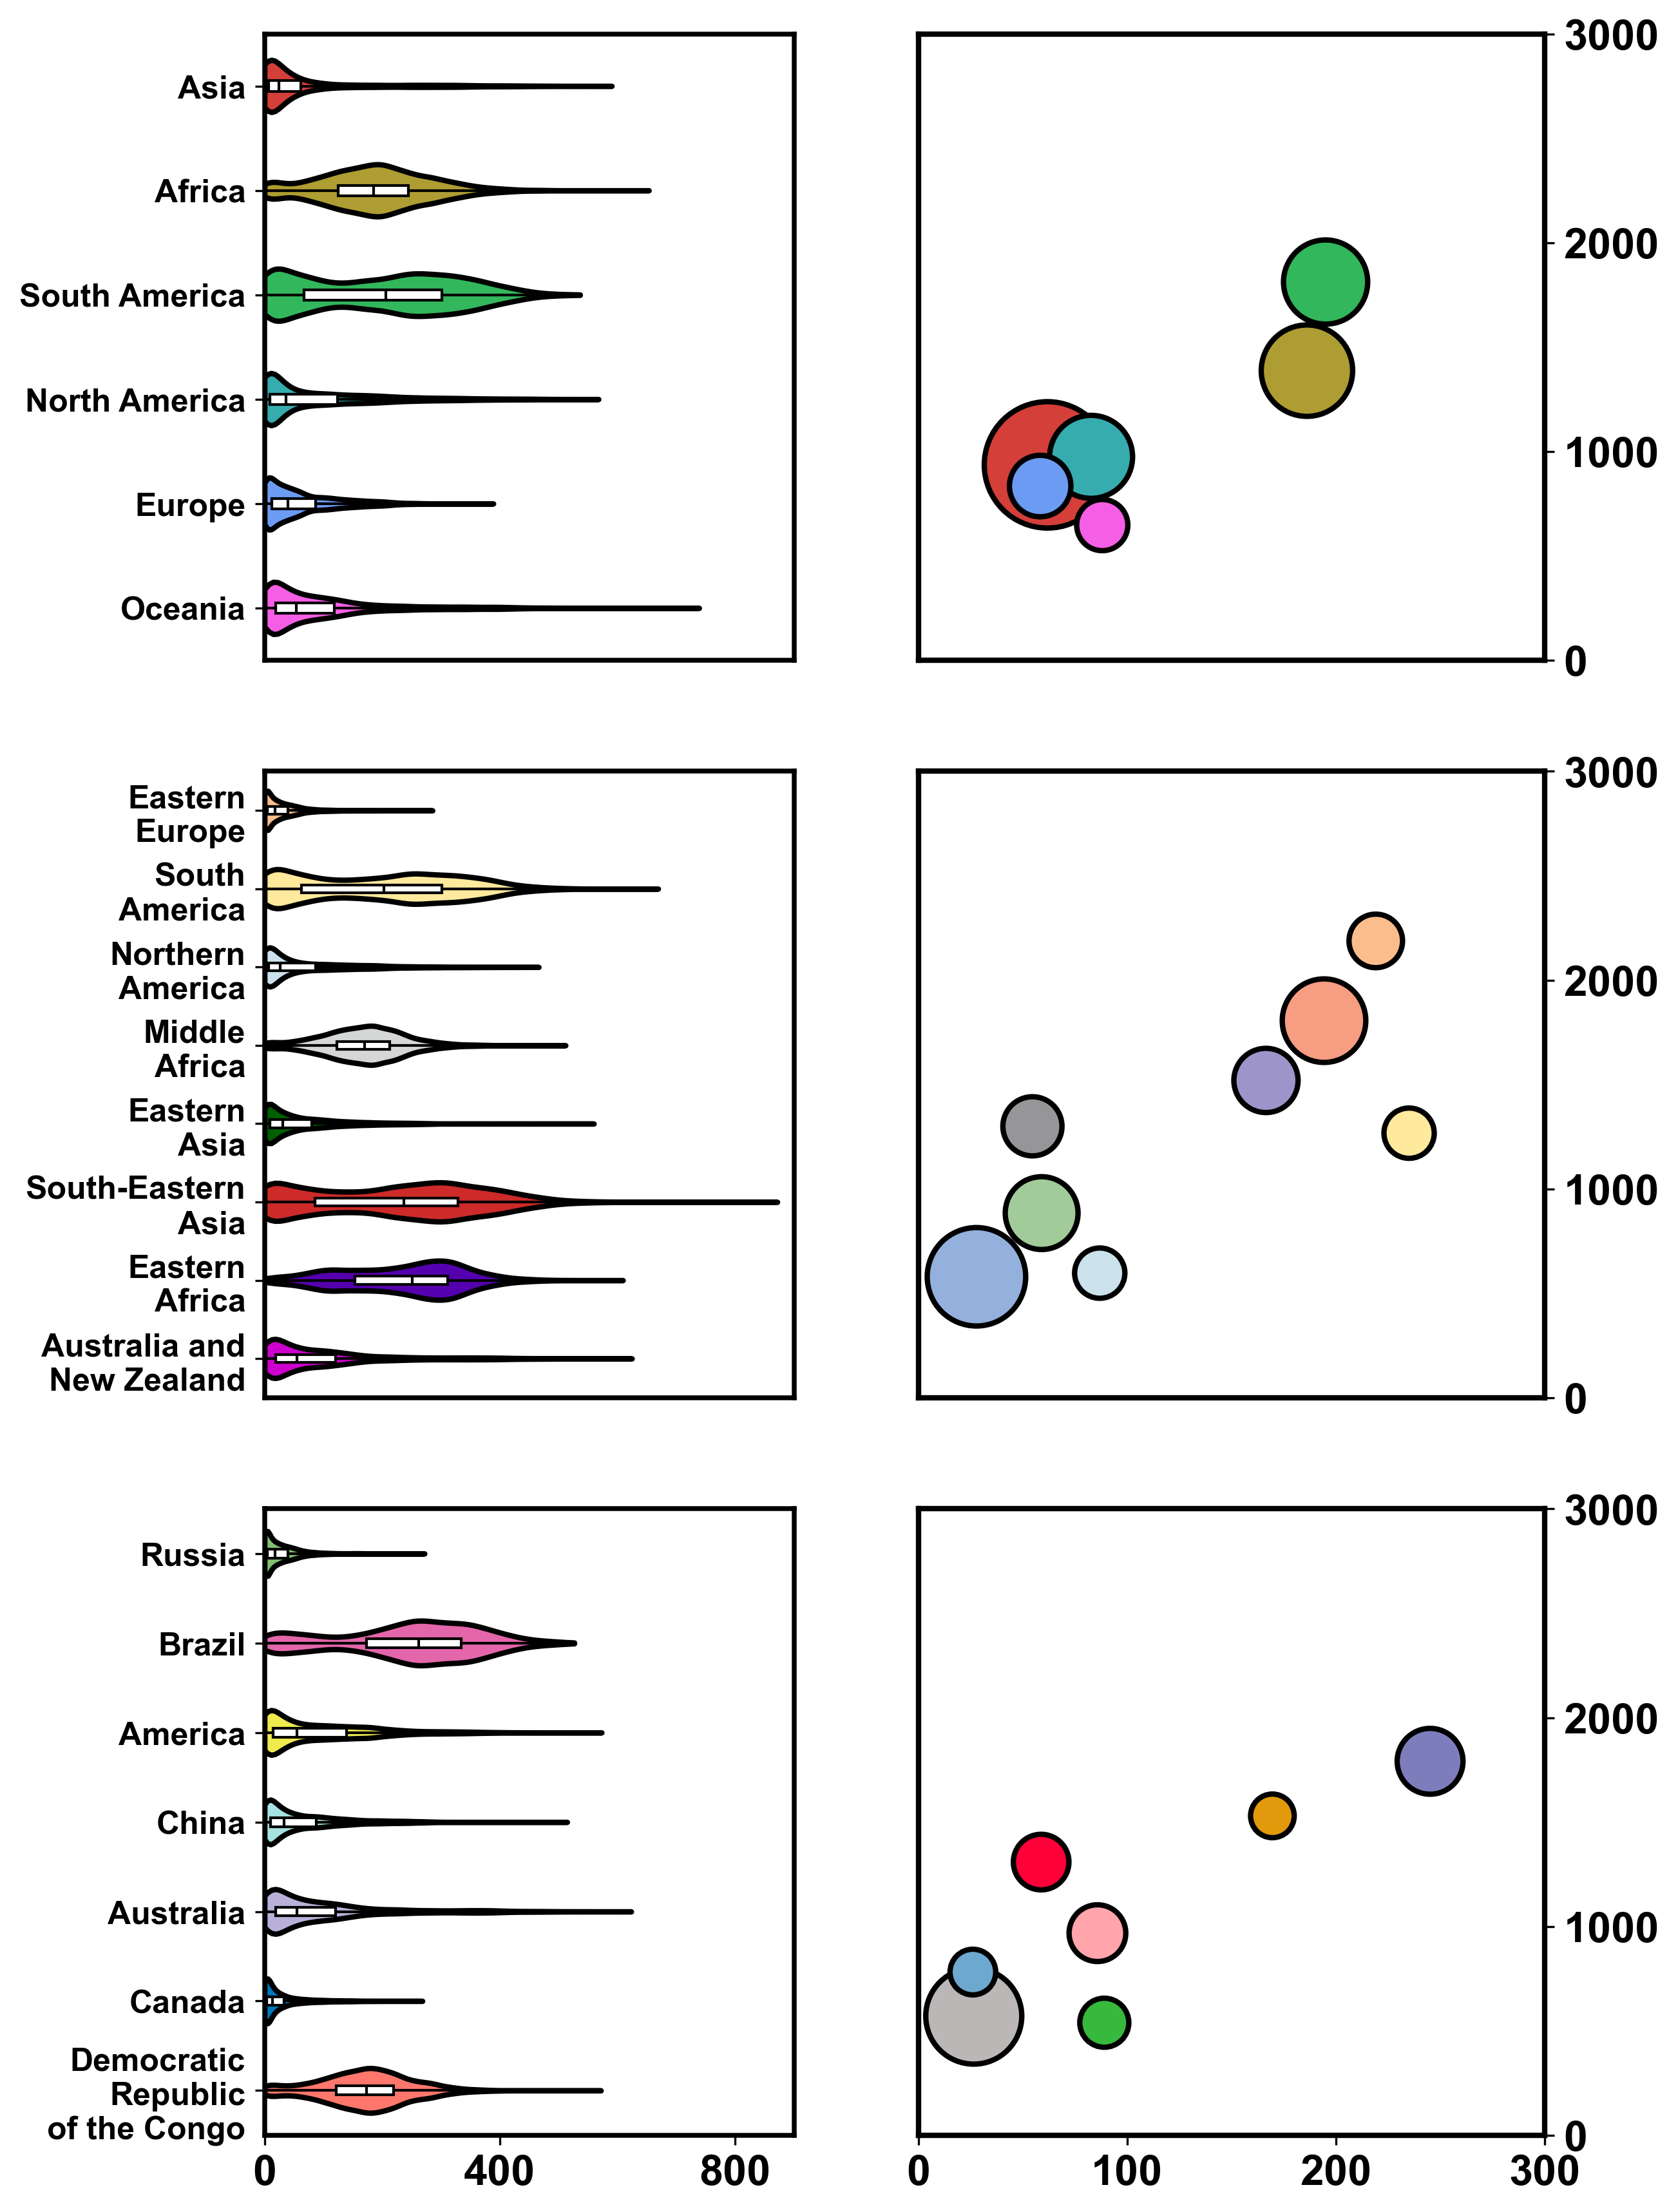

In [9]:
# Define mappings for display names (add newlines)
subregion_mapping = {
    'South America': 'South\nAmerica', 'Australia and New Zealand': 'Australia and\nNew Zealand',
    'Southern Africa': 'Southern\nAfrica', 'Eastern Africa': 'Eastern\nAfrica', 'Melanesia': 'Melanesia',
    'Western Europe': 'Western\nEurope', 'Polynesia': 'Polynesia', 'Middle Africa': 'Middle\nAfrica',
    'South-Eastern Asia': 'South-Eastern\nAsia', 'Western Africa': 'Western\nAfrica',
    'Southern Asia': 'Southern\nAsia', 'Central America': 'Central\nAmerica', 'Northern Africa': 'Northern\nAfrica',
    'Caribbean': 'Caribbean', 'Western Asia': 'Western\nAsia', 'Eastern Asia': 'Eastern\nAsia',
    'Northern America': 'Northern\nAmerica', 'Southern Europe': 'Southern\nEurope',
    'Central Asia': 'Central\nAsia', 'Eastern Europe': 'Eastern\nEurope', 'Northern Europe': 'Northern\nEurope'
}
sovereignt_mapping = {
    'United States of America': 'America', 'Democratic Republic of the Congo': 'Democratic\nRepublic\nof the Congo',
    'Central African Republic': 'Central\nAfrican Republic'
}

# Process data
try:
    
    # Process by Continent
    categories1, values1, mean_data1 = process_geo_data(df, 'Continent')
    
    # Process by Subregion
    categories2, values2, mean_data2 = process_geo_data(df, 'Subregion', name_mapping=subregion_mapping)
    
    # Process by Sovereignt
    categories3, values3, mean_data3 = process_geo_data(df, 'Sovereignt', name_mapping=sovereignt_mapping)

    # Print mean data
    print("Continent Data:\n", mean_data1)
    print("Subregion Data:\n", mean_data2)
    print("Sovereignt Data:\n", mean_data3)
    print("Number of countries:", len(mean_data3))

    # Create figure
    fig = plt.figure(figsize=(9, 12), dpi=300, constrained_layout=True)
    gs = GridSpec(6, 7, figure=fig)

    # Create subplots
    ax1 = fig.add_subplot(gs[0:2, 0:3])  # Violin: Continent
    ax2 = fig.add_subplot(gs[2:4, 0:3])  # Violin: Subregion
    ax3 = fig.add_subplot(gs[4:6, 0:3])  # Violin: Country
    ax4 = fig.add_subplot(gs[0:2, 3:7])  # Scatter: Continent
    ax5 = fig.add_subplot(gs[2:4, 3:7])  # Scatter: Subregion
    ax6 = fig.add_subplot(gs[4:6, 3:7])  # Scatter: Country

    # Colors for plots
    colors1 = ['#D43F3A', '#ae9d32', '#32b75c', '#36acae', '#6c9bf4', '#f55fe5']
    colors2 = ['#94b0dc', '#f79d82', '#a1cc9a', '#9d95c9', '#969597', '#fbbd8c', 
               '#fee99c', '#cbe2ed', '#d5d6d6', '#005f00', '#cd2a29', '#5500ae', '#cc00cc']
    colors3 = ['#bab7b6', '#7e7dbc', '#ffa5ab', '#ff0038', '#37b93d', '#6da9cf', 
               '#e2990b', '#82c06e', '#e366ab', '#efeb4f', '#a7e2e2', '#b9b0d9', 
               '#0178bd', '#ff776c']

    # Draw violin plots
    violin_draw(ax1, values1[::-1], categories1[::-1], 'Continent', colors1[::-1])
    ax1.set_xticks([])
    violin_draw(ax2, values2[::-1], categories2[::-1], 'Sub-continent', colors2[::-1])
    ax2.set_xticks([])
    violin_draw(ax3, values3[::-1], categories3[::-1], 'Country', colors3[::-1])
    ax3.set_xticks(np.arange(0, 1000, 400))
    ax3.set_xticklabels(np.arange(0, 1000, 400), fontsize=16, fontweight='bold')

    # Draw scatter plots
    scatter_draw(ax4, mean_data1['PR_mean'], mean_data1['Sbedrock'], mean_data1['Area'], 
                 colors1, title='Continent')
    ax4.set_xticks([])
    scatter_draw(ax5, mean_data2['PR_mean'], mean_data2['Sbedrock'], mean_data2['Area'], 
                 colors2, title='Sub-continent')
    ax5.set_xticks([])
    scatter_draw(ax6, mean_data3['PR_mean'], mean_data3['Sbedrock'], mean_data3['Area'], 
                 colors3, title='Country')
    ax6.set_xticks(np.arange(0, 350, 100))
    ax6.set_xticklabels(np.arange(0, 350, 100), fontsize=16, fontweight='bold')
    
    plt.tight_layout() 
    plt.show()

except Exception as e:
    print(f"Error processing or plotting data: {e}")